In [1]:
# loading libraries
%load_ext autoreload
%autoreload 2
import sys, os, re
from collections import Counter
import pandas as pd
import numpy as np
sys.path.append(os.path.abspath('../Code'))
from helpers import cumulative_fraction, grams, transpose_note_list, transition_matrix
from plot_helpers import *
#from expand_labels import expand_labels, SliceMaker, fifths2name
from ms3.utils import load_tsv, fifths2name, fifths2name, fifths2pc
from ms3.expand_dcml import SM
from ms3 import Parse
#from harmony import regex
#REGEX = re.compile(regex, re.VERBOSE)
from plotly.subplots import make_subplots
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

In [2]:
# Helper functions
def color_chord_tones(df, chord_tones):
    k = len(df.columns)
    df = df.reindex(sort_tpcs(df.index, start=chord_tones[0]))
    return df.style.apply(lambda S: ['background-color: yellow']*k if S.name in chord_tones else ['']*k, axis=1)

def distinguish_chord_tones(chord_segment, chord):
    """Calculate statistics for the intervals contained in a note list.
    
    Parameters
    ----------
    chord_segment : pd.DataFrame
        Note list representing one or several chords.
    chord : str
        Chord label that the note list represents.
    """
    chord_tones = chord2tpcs(chord)
            
    mask = chord_segment.gracenote.isna()
    chord_notes = chord_segment[mask]
    all_notes = chord_notes.tpc.astype(int).unique()
    res = {}
    total_duration = chord_notes.duration.sum()
    if total_duration == 0:
        return pd.Series(dtype=object)
    for tpc in all_notes:
        sel = chord_notes[(chord_notes.tpc == tpc)]
        tot = len(sel)
        res[('count', tpc)] = tot
        res[('duration_frac', tpc)] = float(sel.duration.sum() / total_duration)
        res[('duration_mean', tpc)] = sel.duration.mean()
        onbeat = (sel.subbeat == 0) & ~sel.overlapping.isin([0, -1])
        res[('onbeat', tpc)] = len(sel[onbeat]) / tot
        #res[('offbeat', tpc)] = round(len(sel[~onbeat]) / tot, 2)
    res = pd.Series(res).unstack().T
    k = len(res.columns)
    res = res.reindex(sort_tpcs(res.index, start=chord_tones[0]))
    #res = res.style.apply(lambda S: ['background-color: yellow']*k if S.name in chord_tones else ['']*k, axis=1)
    return res

def divide_maj_min(cl, k=30):
    cl_min = cl[cl.localminor]
    cl_maj = cl[~cl.localminor]
    tokens = len(cl)
    print(f"{len(cl_maj)/tokens:.2%} in major, {len(cl_min)/tokens:.2%} in minor")
    cum_min = cumulative_fraction(cl_min.chord)
    cum_maj = cumulative_fraction(cl_maj.chord)
    cum_both = cum_maj.reset_index().rename(columns={'index': 'major', 'x': 'maj_count', 'y': 'maj_cum'}).join(
        cum_min.reset_index().rename(columns={'index': 'minor', 'x': 'min_count', 'y': 'min_cum'}))
    cum_both.index = cum_both.index + 1
    display(cum_both.head(k))
    return cl_maj, cl_min

def get_tone_distribution(chord, minor=False, sort_tpc=True):
    try:
        cn = min_notes.loc[chord] if minor else maj_notes.loc[chord]
    except:
        return pd.DataFrame()
    complete = distinguish_chord_tones(cn, chord)
    dis = {'average': complete}
    for sc, ids in sc_ids.iteritems():
        df = distinguish_chord_tones(cn.loc[ids], chord)
        dis[sc] = df
    df = pd.concat(dis.values(), keys=dis.keys(), axis=1)
    if sort_tpc:
        chord_tones = chord2tpcs(chord)
        df = df.reindex(sort_tpcs(df.index, start=chord_tones[0]))
    return df

def notes_by_type(cn, cl, slic=SM[:]):
    chords = cl.chord.value_counts().iloc[slic].index.to_list()
    return cl[cl.chord.isin(chords)].groupby('chord').apply(lambda cl: chords_by_id(cn, cl)), chords

def plot_non_chord_tones(chord, minor=False, only_chord_tones=True, norm=True, return_figs=False):
    chord_tones = chord2tpcs(chord, minor=minor)
    dis = get_tone_distribution(chord, minor)
    df = dis.loc[:, idx[:, 'duration_frac']].droplevel(1, axis=1)
    if only_chord_tones:
        ct = df[['average'] + [k for k in sc_order.keys() if k in df.columns]].loc[chord_tones].T
    else:
        # without merging non-chord-tones
        # ct = df[['average'] + [k for k in sc_order.keys() if k in df.columns]].loc[df.sum(axis=1).sort_values(ascending=False).index].T
        ct = df[['average'] + [k for k in sc_order.keys() if k in df.columns]].rename(lambda x: x if x in chord_tones else 'other').groupby(level=0).sum().T
    if norm:
        ct = ct.div(ct.sum(axis=1), axis='index')
    agg = df[['average'] + [k for k in sc_order.keys() if k in df.columns]].loc[[i for i in df.index if not i in chord_tones]]
    ct_names = tpc2name(chord_tones)
    fig1 = df.rename(tpc2name).iplot('bar', title=f"Chord tones {ct_names} and non-chord tones of all {chord} chords in {'minor' if minor else 'major'}", 
                                     xTitle='Tonal Pitch Class', 
                                     yTitle='Fraction', 
                                     asFigure=True)
    fig2 = ct.rename(columns=tpc2name).iplot('bar', barmode='stack', 
                                             title=f"{'Normalised d' if norm else 'D'}istribution of chord tones {ct_names} within all {chord} chords in {'minor' if minor else 'major'}", 
                                             yTitle='Fraction', 
                                             asFigure=True)
    fig3 = agg.sum().iplot('bar', title=f"Fraction of non-chord tones in all {chord} chords in {'minor' if minor else 'major'}", 
                           yTitle='Fraction', 
                           asFigure=True)
    if return_figs:
        return fig1, fig2, fig3
    else:
        fig1.show()
        fig2.show()
        fig3.show()

def summarize_corpus(S, k=20, x_log=False):
    cum = cumulative_fraction(S).reset_index()
    cum.index = cum.index + 1
    types = len(cum)
    tokens = cum.x.sum()
    print(f"{types} types, {tokens} tokens, TTR={types/tokens:.1%}")
    display(cum.rename(columns={'index': 'chord label', 'x': 'chord counts', 'y': 'cumulative fraction'}).head(k))
    return plot_cum(cum=cum, x_log=x_log)
    

    
def summarize_ivs(chord_segment, bass=None, exclude_bass=False):
    """Calculate statistics for the intervals contained in a note list.
    
    Parameters
    ----------
    chord_segment : pd.DataFrame
        Note list representing one or several chords.
    bass : str or int, optional
        If you don't specify the tonal pitch class of the bass note, the first note is taken as bass.
    exclude_bass : bool, optional
        Pass True to exclude the bass note (interval P1) from the stats.
    """
    if bass is None:
        bass_tpc = chord_segment.tpc.iloc[0]
    else:
        bass_tpc = name2tpc(bass) if bass.__class__ == str else bass
            
    mask = (chord_segment.tpc != bass_tpc) & chord_segment.gracenote.isna() if exclude_bass else chord_segment.gracenote.isna()
    chord_notes = chord_segment[mask].copy()
    chord_notes['intervals'] = tpc2iv(chord_notes.tpc - bass_tpc)
    intervals = sort_intervals(set(chord_notes.intervals.values))
    res = {}
    total_duration = chord_notes.duration.sum()
    if len(intervals) == 0 or total_duration == 0:
        return res
    for iv in intervals:
        sel = chord_notes[(chord_notes.intervals == iv)]
        tot = len(sel)
        res[('count', iv)] = tot
        res[('duration_frac', iv)] = round(float(sel.duration.sum() / total_duration), 2)
        res[('duration_mean', iv)] = frac(sel.duration.mean())
        onbeat = (sel.subbeat == 0) & ~sel.overlapping.isin([0, -1])
        res[('onbeat', iv)] = round(len(sel[onbeat]) / tot, 2)
        #res[('offbeat', iv)] = round(len(sel[~onbeat]) / tot, 2)
    return pd.Series(res).sort_index(level=0, sort_remaining=False)
                                     
                                     
def plot_cum(S=None, cum=None, x_log=False, markersize=2, left_range=(-0.1, 4.40), right_range=(-0.023,1.099), **kwargs):
    """Pass either a Series or cumulative_fraction(S).reset_index()"""
    if cum is None:
        cum = cumulative_fraction(S).reset_index()
        cum.index = cum.index + 1
    fig = make_subplots(specs=[[{"secondary_y": True,}]])
    ix = cum.index
    fig.add_trace(
        go.Scatter(x=ix, y=cum.x, text=cum['index'], name="Absolute count", mode='markers', marker=dict(size=markersize)),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=ix, y=cum.y, text=cum['index'], name="Cumulative fraction", mode='markers', marker=dict(size=markersize)),
        secondary_y=True,
    )
    fig.update_xaxes(title_text="Rank of chord label", zeroline=False, gridcolor='lightgrey')
    if x_log:
        ranks = np.log(len(ix))/np.log(10)
        fig.update_xaxes(type='log', range=(-0.01*ranks, 1.01*ranks))
    else:
        ranks = len(ix)
        fig.update_xaxes(range=(-0.02*ranks, 1.02*ranks))
    fig.update_yaxes(title_text="Absolute label count", secondary_y=False, type='log', gridcolor='grey', zeroline=True, dtick=1, range=left_range)
    fig.update_yaxes(title_text="Cumulative fraction", secondary_y=True, gridcolor='lightgrey', zeroline=False, dtick=0.1, range=right_range)
    fig.update_layout(**kwargs)
    return fig

def transition_matrix(l=None, gs=None, n=2, k=None, smooth=0, normalize=False, IC=False, filt=None, dist_only=False,sort=False, decimals=2):
    """Returns a transition table from a list of symbols.

    Column index is the last item of grams, row index the n-1 preceding items.

    Parameters
    ----------

    l: list, optional
        List of elements between which the transitions are calculated.
        List can be nested.
    gs: list, optional
        List of tuples being n-grams
    n: int, optional
        get n-grams
    k: int, optional
        Number of rows and columns that you want to keep
    smooth: number, optional
        initial count value of all transitions
    normalize: bool, optional
        set True to divide every row by the sum of the row.
    IC: bool, optional
        Set True to calculate information content.
    filt: list, optional
        elements you want to exclude from the table. All ngrams containing at least one
        of the elements will be filtered out.
    dist_only: bool, optional
        if True, n-grams consisting only of identical elements are filtered out
    """
    if gs is None:
        assert (n>0), f"Cannot print {n}-grams"
        gs = grams(l, n=n)
    elif l is not None:
        assert True, "Specify either l or gs, not both."

    if filt:
        gs = list(filter(lambda n: not any(g in filt for g in n),gs))
    if dist_only:
        gs = list(filter(lambda tup: any(e != tup[0] for e in tup),gs))
    ngrams = pd.Series(gs).value_counts()
    ngrams.index = [(' '.join(t[:-1]),t[-1]) for t in ngrams.index.tolist()]
    context = pd.Index(set([ix[0] for ix in ngrams.index]))
    consequent = pd.Index(set([ix[1] for ix in ngrams.index]))
    df = pd.DataFrame(smooth, index=context, columns=consequent)


    for i, (cont, cons) in enumerate(ngrams.index):
        try:
            df.loc[cont, cons] += ngrams[i]
        except:
            continue



    if k is not None:
        sort=True

    if sort:
        h_sort = list(df.max().sort_values(ascending= False).index.values)
        v_sort = list(df.max(axis=1).sort_values(ascending= False).index.values)
        df = df[h_sort].loc[v_sort]

    SU = df.sum(axis=1)
    if normalize or IC:
        df = df.div(SU,axis=0)

    if IC:
        ic = np.log2(1/df)
        ic['entropy'] = (ic * df).sum(axis=1)
        ############## Identical calucations:
        #ic['entropy2'] = scipy.stats.entropy(df.transpose(),base=2)
        #ic['entropy3'] = -(df * np.log2(df)).sum(axis=1)
        df = ic
        if normalize:
            df['entropy'] = df['entropy'] / np.log2(len(df.columns)-1)
    else:
        df['total'] = SU

    if k is not None:
        df = df.iloc[:k, :k]

    if decimals is not None:
        df = df.round(decimals)

    return df

# Use ms3 to parse the expanded harmony TSVs

In [3]:
Parse('.',  file_re='tsv$', index='fname', folder_re='harmonies')

97 files.
KEY                                 -> EXTENSIONS
-------------------------------------------------
Couperin-gouts_reunis/harmonies     -> {'.tsv': 58}
Couperin-L'art_de_toucher/harmonies -> {'.tsv': 13}
Couperin-concerts_royaux/harmonies  -> {'.tsv': 26}

In [4]:
p = Parse('.', key='coup', file_re='tsv$', index='fname', folder_re='harmonies')
p.parse_tsv()

In [5]:
p

97 files.
KEY  -> EXTENSIONS
------------------
coup -> {'.tsv': 97}

All 97 tabular files have been parsed, 97 of them as Annotations object(s).
KEY  -> ANNOTATION LAYERS
-------------------------
coup -> staff  voice  label_type
     -> 1      1      3             9522
     ->        2      3               17
     -> 2      1      3                3
     -> 1      1      0               14

In [6]:
df = p.get_labels()
df['key_regions'] = df.groupby(level=0).localkey.apply(lambda col: col != col.shift()).cumsum()
df

mc  mn mc_onset mn_onset timesig  staff  voice  label  \
fname                                                                     
00_allemande 0     1   0        0     5/16     4/4      1      1   .d.V   
             1     1   0     3/16      1/2     4/4      1      1     i6   
             2     1   0     7/16      3/4     4/4      1      1      i   
             3     2   1        0        0     4/4      1      1     V6   
             4     2   1      1/4      1/4     4/4      1      1      V   
...               ..  ..      ...      ...     ...    ...    ...    ...   
parnasse_07  219  52  52      3/8      3/8     4/4      1      1    i64   
             220  52  52     7/16     7/16     4/4      1      1  iio64   
             221  52  52      1/2      1/2     4/4      1      1     i6   
             222  52  52      3/4      3/4     4/4      1      1      V   
             223  53  53        0        0     4/4      1      1    i\\   

                 alt_label globalkey localkey pedal  chord numeral form  \
fname                                                                     
00_allemande 0         NaN         d        i   NaN      V       V  NaN   
             1         NaN         d        i   NaN     i6       i  NaN   
             2         NaN         d        i   NaN      i       i  NaN   
             3         NaN         d        i   NaN     V6       V  NaN   
             4         NaN         d        i   NaN      V       V  NaN   
...                    ...       ...      ...   ...    ...     ...  ...   
parnasse_07  219       NaN         b        i   NaN    i64       i  NaN   
             220       NaN         b        i   NaN  iio64      ii    o   
             221       NaN         b        i   NaN     i6       i  NaN   
             222       NaN         b        i   NaN      V       V  NaN   
             223       NaN         b        i   NaN      i       i  NaN   

                 figbass changes relativeroot phraseend chord_type  \
fname                                                                
00_allemande 0       NaN     NaN          NaN       NaN          M   
             1         6     NaN          NaN       NaN          m   
             2       NaN     NaN          NaN       NaN          m   
             3         6     NaN          NaN       NaN          M   
             4       NaN     NaN          NaN       NaN          M   
...                  ...     ...          ...       ...        ...   
parnasse_07  219      64     NaN          NaN       NaN          m   
             220      64     NaN          NaN       NaN          o   
             221       6     NaN          NaN       NaN          m   
             222     NaN     NaN          NaN       NaN          M   
             223     NaN     NaN          NaN        \\          m   

                  globalkey_is_minor  localkey_is_minor  chord_tones  \
fname                                                                  
00_allemande 0                  True               True    (1, 5, 2)   
             1                  True               True   (-3, 1, 0)   
             2                  True               True   (0, -3, 1)   
             3                  True               True    (5, 2, 1)   
             4                  True               True    (1, 5, 2)   
...                              ...                ...          ...   
parnasse_07  219                True               True   (1, 0, -3)   
             220                True               True  (-4, 2, -1)   
             221                True               True   (-3, 1, 0)   
             222                True               True    (1, 5, 2)   
             223                True               True   (0, -3, 1)   

                 added_tones  root  bass_note label_type rightParen  \
fname                                                                 
00_allemande 0            ()     1          1          3        NaN   
     

In [7]:
df.index.is_unique

True

# Unigrams

In [8]:
df.chord.value_counts()

V              1269
I              1078
i               835
V7              495
V65             474
I6              456
i6              408
V43             312
ii%65           240
IV              236
V2              189
ii65            178
V6              159
V(4)            154
ii              138
iv              132
vi              132
ii%43           127
IV6             112
V(64)           108
iv6              89
ii7              85
ii6              71
v6               70
i64              67
VI               60
VIM7             49
V65/iv           48
iv7              44
V65/V            40
I64              39
V43/V            38
ii%7             37
III              36
viio6            35
v                35
iio              35
vi7              35
ii43             32
V/iv             31
IVM7             30
vi6              30
iii6             27
V7/IV            27
III+6            25
V7/iv            25
VII              24
V7(4)            22
I(4)             22
III6             22


In [9]:
STD_LAYOUT

{'paper_bgcolor': '#FFFFFF',
 'plot_bgcolor': '#FFFFFF',
 'margin': {'l': 40, 'r': 0, 'b': 0, 't': 0, 'pad': 0}}

In [10]:
font_dict = {'font': {'size': 20}}
STD_LAYOUT.update(font_dict)
H_LAYOUT = STD_LAYOUT.copy()
H_LAYOUT.update({'legend': dict({'orientation': 'h', 'itemsizing':'constant', 'x': -0.05}, **font_dict)})

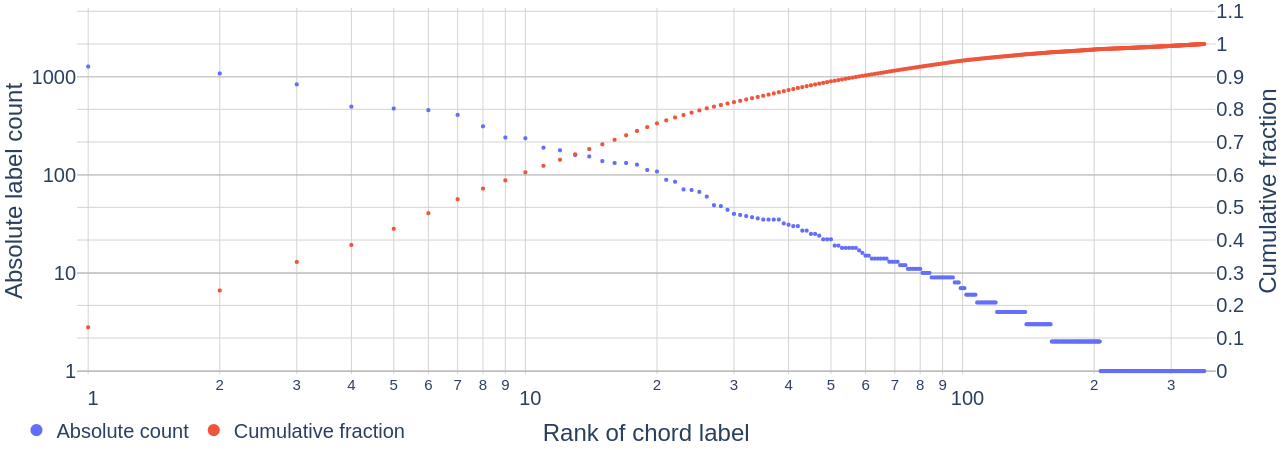

In [11]:
fig = plot_cum(df.chord, x_log=True, markersize=4, left_range=(-0.03, 3.7), right_range=(-0.01,1.11), **H_LAYOUT)
store(fig, 'type_distribution.eps', height=400)
#fig.show()

In [12]:
df.chord.value_counts()

V              1269
I              1078
i               835
V7              495
V65             474
I6              456
i6              408
V43             312
ii%65           240
IV              236
V2              189
ii65            178
V6              159
V(4)            154
ii              138
iv              132
vi              132
ii%43           127
IV6             112
V(64)           108
iv6              89
ii7              85
ii6              71
v6               70
i64              67
VI               60
VIM7             49
V65/iv           48
iv7              44
V65/V            40
I64              39
V43/V            38
ii%7             37
III              36
viio6            35
v                35
iio              35
vi7              35
ii43             32
V/iv             31
IVM7             30
vi6              30
iii6             27
V7/IV            27
III+6            25
V7/iv            25
VII              24
V7(4)            22
I(4)             22
III6             22


# Bigrams

In [13]:
chord_successions = [s.to_list() for _, s in df.groupby('key_regions').chord]

In [14]:
gs = grams(chord_successions)
c = Counter(gs)

In [15]:
sorted(c.items(), key=lambda a: a[1], reverse=True)

[(('V', 'I'), 270),
 (('V7', 'I'), 224),
 (('V', 'i'), 210),
 (('I', 'V'), 180),
 (('V', 'V7'), 156),
 (('V65', 'I'), 154),
 (('i', 'V'), 154),
 (('V7', 'i'), 137),
 (('ii%65', 'V'), 126),
 (('V', 'I6'), 126),
 (('V65', 'i'), 119),
 (('V(4)', 'V'), 109),
 (('V65', 'V7'), 107),
 (('V43', 'i'), 89),
 (('I6', 'I'), 89),
 (('ii65', 'V'), 88),
 (('V43', 'I'), 85),
 (('V2', 'i6'), 83),
 (('V', 'i6'), 82),
 (('i6', 'V43'), 79),
 (('I', 'I6'), 78),
 (('V2', 'I6'), 72),
 (('V', 'V2'), 70),
 (('i6', 'ii%65'), 69),
 (('I6', 'V43'), 65),
 (('I6', 'ii65'), 64),
 (('i6', 'i'), 59),
 (('V(64)', 'V'), 59),
 (('i', 'i6'), 56),
 (('i', 'V65'), 56),
 (('IV6', 'V65'), 53),
 (('I', 'V6'), 50),
 (('V', 'V65'), 50),
 (('I', 'IV'), 49),
 (('I', 'I'), 48),
 (('I', 'V65'), 48),
 (('ii', 'V'), 44),
 (('V43', 'i6'), 44),
 (('ii%43', 'ii%65'), 44),
 (('IV', 'ii'), 43),
 (('I', 'vi'), 42),
 (('ii%43', 'V'), 42),
 (('I6', 'IV'), 41),
 (('i6', 'V65'), 40),
 (('i', 'ii%65'), 38),
 (('I', 'ii65'), 37),
 (('I6', 'V'), 3

## Absolute Counts (read from index to column)

In [16]:
transition_matrix(chord_successions, k=20, dist_only=True)

,I,i,V,V7,I6,i6,V43,V2,ii%65,ii65,V65,V6,IV,ii,vi,V(4),ii%43,v6,iv,V(64)
V,270,210,0,156,126,82,12,70,4,0,50,22,4,14,7,0,9,5,0,1
V7,224,137,3,0,3,8,1,1,0,0,9,0,0,0,17,1,0,0,0,18
I,0,6,180,28,78,0,22,8,0,37,48,50,49,2,42,32,0,0,1,15
i,4,0,154,3,0,56,27,9,38,3,56,15,14,1,0,14,20,28,11,3
V65,154,119,17,107,2,10,6,3,0,0,0,1,0,0,1,0,1,0,0,0
ii%65,0,10,126,4,0,16,1,7,0,0,2,0,0,0,0,23,5,0,0,12
V(4),0,0,109,21,1,0,0,0,0,0,1,2,0,0,0,0,1,0,0,2
I6,89,0,32,1,0,0,65,1,0,64,9,9,41,1,17,14,0,0,0,10
V43,85,89,5,5,26,44,0,2,0,0,28,2,0,0,0,0,0,0,0,1
ii65,7,1,88,6,3,0,0,7,0,0,1,0,0,3,0,20,0,0,0,10


## Normalized Counts

In [17]:
transition_matrix(chord_successions, k=20, dist_only=True, normalize=True, decimals=2)

,I,i,V,V7,I6,i6,V43,V2,ii%65,ii65,V65,V6,IV,ii,vi,V(4),ii%43,v6,iv,V(64)
V,0.22,0.17,0.00,0.13,0.10,0.07,0.01,0.06,0.00,0.00,0.04,0.02,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.00
V7,0.46,0.28,0.01,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.04
I,0.00,0.01,0.23,0.04,0.10,0.00,0.03,0.01,0.00,0.05,0.06,0.07,0.06,0.00,0.05,0.04,0.00,0.00,0.00,0.02
i,0.01,0.00,0.24,0.00,0.00,0.09,0.04,0.01,0.06,0.00,0.09,0.02,0.02,0.00,0.00,0.02,0.03,0.04,0.02,0.00
V65,0.33,0.25,0.04,0.23,0.00,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ii%65,0.00,0.04,0.52,0.02,0.00,0.07,0.00,0.03,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.10,0.02,0.00,0.00,0.05
V(4),0.00,0.00,0.71,0.14,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01
I6,0.20,0.00,0.07,0.00,0.00,0.00,0.14,0.00,0.00,0.14,0.02,0.02,0.09,0.00,0.04,0.03,0.00,0.00,0.00,0.02
V43,0.27,0.29,0.02,0.02,0.08,0.14,0.00,0.01,0.00,0.00,0.09,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ii65,0.04,0.01,0.50,0.03,0.02,0.00,0.00,0.04,0.00,0.00,0.01,0.00,0.00,0.02,0.00,0.11,0.00,0.00,0.00,0.06


## Entropy

In [18]:
transition_matrix(chord_successions, k=20, IC=True, dist_only=True, smooth=1, decimals=2)

,I,i,V,V7,I6,i6,V43,V2,ii%65,ii65,V65,V6,IV,ii,vi,V(4),ii%43,v6,iv,V(64)
V,2.52,2.88,10.60,3.31,3.62,4.23,6.90,4.45,8.28,10.60,4.93,6.08,8.28,6.70,7.60,10.60,7.28,8.02,10.60,9.60
V7,1.90,2.60,7.71,9.71,7.71,6.54,8.71,8.71,9.71,9.71,6.39,9.71,9.71,9.71,5.54,8.71,9.71,9.71,9.71,5.46
I,10.13,7.32,2.63,5.27,3.83,10.13,5.61,6.96,10.13,4.88,4.51,4.46,4.49,8.54,4.70,5.08,10.13,10.13,9.13,6.13
i,7.64,9.96,2.69,7.96,9.96,4.13,5.16,6.64,4.68,7.96,4.13,5.96,6.06,8.96,9.96,6.06,5.57,5.11,6.38,7.96
V65,2.41,2.78,5.51,2.93,8.10,6.22,6.88,7.68,9.68,9.68,9.68,8.68,9.68,9.68,8.68,9.68,8.68,9.68,9.68,9.68
ii%65,9.21,5.75,2.22,6.89,9.21,5.12,8.21,6.21,9.21,9.21,7.62,9.21,9.21,9.21,9.21,4.62,6.62,9.21,9.21,5.51
V(4),8.98,8.98,2.20,4.52,7.98,8.98,8.98,8.98,8.98,8.98,7.98,7.40,8.98,8.98,8.98,8.98,7.98,8.98,8.98,7.40
I6,3.15,9.64,4.60,8.64,9.64,9.64,3.60,8.64,9.64,3.62,6.32,6.32,4.25,8.64,5.47,5.74,9.64,9.64,9.64,6.18
V43,2.95,2.88,6.79,6.79,4.62,3.88,9.37,7.79,9.37,9.37,4.51,7.79,9.37,9.37,9.37,9.37,9.37,9.37,9.37,8.37
ii65,6.04,8.04,2.57,6.24,7.04,9.04,9.04,6.04,9.04,9.04,8.04,9.04,9.04,7.04,9.04,4.65,9.04,9.04,9.04,5.58


## Minor vs. Major

In [19]:
region_is_minor = df.groupby('key_regions').localkey_is_minor.unique().map(lambda l: l[0]).to_dict()

In [20]:
key_chords = {ix: s.to_list() for ix, s in df.reset_index().groupby(['fname', 'key_regions']).chord}
major, minor = [], []
for chords, is_minor in zip(key_chords.values(), region_is_minor.values()):
    (major, minor)[is_minor].append(chords)

In [21]:
transition_matrix(major, k=20, dist_only=True, normalize=True)

,I,V,I6,V7,V43,ii65,V6,IV,V65,vi,V2,ii,V(4),iii6,V(64),IVM7,ii7,IV64,V43/V,vi6
V,0.38,0.00,0.20,0.13,0.00,0.00,0.02,0.00,0.04,0.01,0.05,0.02,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00
V7,0.74,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.06,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00
I,0.00,0.24,0.10,0.04,0.03,0.05,0.07,0.07,0.06,0.06,0.01,0.00,0.04,0.00,0.02,0.02,0.00,0.02,0.01,0.02
V65,0.63,0.03,0.01,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
I6,0.20,0.07,0.00,0.00,0.15,0.14,0.02,0.09,0.02,0.04,0.00,0.00,0.03,0.00,0.02,0.01,0.03,0.00,0.00,0.00
V43,0.60,0.02,0.19,0.02,0.00,0.00,0.01,0.00,0.06,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
ii65,0.04,0.48,0.02,0.04,0.00,0.00,0.00,0.00,0.01,0.00,0.04,0.01,0.12,0.01,0.06,0.00,0.05,0.00,0.00,0.00
V2,0.02,0.00,0.80,0.00,0.03,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
V(4),0.00,0.75,0.01,0.12,0.00,0.00,0.02,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00
IV6,0.06,0.05,0.05,0.05,0.01,0.01,0.03,0.07,0.44,0.00,0.00,0.03,0.00,0.02,0.02,0.00,0.02,0.00,0.00,0.00


In [22]:
transition_matrix(minor, k=20, dist_only=True, normalize=True)

,i,V,i6,V43,V7,ii%65,V65,V2,I,v6,ii%43,iv,V(4),VI,iv6,iv7,V6,IV,V(64),i64
V,0.36,0.00,0.14,0.02,0.12,0.01,0.05,0.07,0.05,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.01
i,0.00,0.24,0.09,0.04,0.00,0.06,0.09,0.01,0.00,0.04,0.03,0.02,0.02,0.03,0.01,0.02,0.02,0.02,0.00,0.00
V7,0.62,0.00,0.04,0.00,0.00,0.00,0.02,0.00,0.12,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.04,0.02
ii%65,0.04,0.52,0.07,0.00,0.02,0.00,0.01,0.03,0.00,0.00,0.02,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.05,0.05
V65,0.51,0.05,0.04,0.02,0.23,0.00,0.00,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
V43,0.49,0.01,0.25,0.00,0.01,0.00,0.11,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.03
V2,0.04,0.00,0.83,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
i6,0.15,0.05,0.00,0.19,0.00,0.17,0.10,0.01,0.00,0.00,0.01,0.02,0.01,0.02,0.00,0.02,0.01,0.01,0.01,0.00
ii%43,0.00,0.32,0.04,0.02,0.07,0.35,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.02,0.10
V(4),0.00,0.65,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00


## Chord progressions without changes

In [23]:
df['plain_chords'] = df.numeral + df.figbass.fillna('') + ('/' + df.relativeroot).fillna('')

In [24]:
df.plain_chords.iloc[:50]

fname           
00_allemande  0            V
              1           i6
              2            i
              3           V6
              4            V
              5         IV65
              6           V7
              7           i6
              8            i
              9          VI6
              10          ii
              11         VI6
              12      V7/III
              13         III
              14         V64
              15           i
              16        ii64
              17          iv
              18           V
              19        V/iv
              20      V65/iv
              21       V/VII
              22        VII6
              23          ii
              24         V65
              25           i
              26       #vii6
              27          i6
              28         iv7
              29           V
              30          V7
              31           V
              32          V7
              33          

In [25]:
def remove_subsequent_identical(col):
    return col[col != col.shift()].to_list()
key_regions_plain_chords = df.reset_index().groupby(['fname', 'key_regions']).plain_chords.apply(remove_subsequent_identical)
key_plain_chords = {ix: s for ix, s in key_regions_plain_chords.iteritems()}
major_plain, minor_plain = [], []
for chords, is_minor in zip(key_plain_chords.values(), region_is_minor.values()):
    (major_plain, minor_plain)[is_minor].append(chords)

### Most frequent 3-, 4-, and 5-grams in major

In [26]:
def sorted_gram_counts(l, n=2):
    return {t: count for t, count in sorted(Counter(grams(l, n=n)).items(), key=lambda a: a[1], reverse=True)}

sorted_gram_counts(major_plain, 3)

{('V', 'V7', 'I'): 102,
 ('I', 'V', 'I'): 94,
 ('I6', 'V43', 'I'): 55,
 ('ii65', 'V', 'I'): 55,
 ('V65', 'I', 'V'): 50,
 ('V65', 'V7', 'I'): 44,
 ('V', 'I6', 'I'): 40,
 ('V43', 'I', 'V'): 39,
 ('I6', 'I', 'V'): 36,
 ('ii65', 'V', 'V7'): 36,
 ('I', 'V', 'V7'): 35,
 ('V', 'I', 'V'): 35,
 ('I6', 'ii65', 'V'): 33,
 ('vi', 'ii65', 'V'): 32,
 ('IV6', 'V65', 'I'): 31,
 ('I', 'V', 'I6'): 29,
 ('I', 'V65', 'I'): 29,
 ('V', 'V2', 'I6'): 27,
 ('I6', 'V', 'I'): 25,
 ('I', 'ii65', 'V'): 25,
 ('V65', 'I', 'I6'): 23,
 ('V', 'I', 'I6'): 22,
 ('I', 'I6', 'V'): 20,
 ('V', 'V65', 'I'): 20,
 ('I', 'V7', 'I'): 19,
 ('I', 'I6', 'ii65'): 18,
 ('IV', 'I6', 'V43'): 17,
 ('V7', 'I', 'V7'): 17,
 ('I6', 'V', 'V7'): 16,
 ('I6', 'I', 'IV'): 16,
 ('IV', 'ii', 'V'): 15,
 ('V', 'I', 'vi'): 15,
 ('V2', 'I6', 'ii65'): 15,
 ('V', 'I6', 'V43'): 15,
 ('IV', 'V43', 'I'): 15,
 ('V7', 'I', 'V'): 15,
 ('V7', 'I', 'V65'): 15,
 ('ii', 'V', 'I6'): 14,
 ('V65', 'I', 'ii65'): 14,
 ('V2', 'I6', 'I'): 14,
 ('I', 'IV', 'ii'): 13,
 ('V

In [27]:
sorted_gram_counts(major_plain, 4)

{('ii65', 'V', 'V7', 'I'): 34,
 ('I', 'V', 'V7', 'I'): 28,
 ('I6', 'V43', 'I', 'V'): 21,
 ('vi', 'ii65', 'V', 'I'): 21,
 ('V65', 'I', 'V', 'I'): 19,
 ('V', 'I6', 'I', 'V'): 18,
 ('IV', 'I6', 'V43', 'I'): 16,
 ('V43', 'I', 'V', 'I'): 16,
 ('I6', 'V', 'V7', 'I'): 15,
 ('V', 'I6', 'V43', 'I'): 15,
 ('I6', 'ii65', 'V', 'I'): 15,
 ('I6', 'I', 'V', 'I'): 14,
 ('I', 'ii65', 'V', 'I'): 13,
 ('I6', 'ii65', 'V', 'V7'): 12,
 ('IV', 'V43', 'I', 'V'): 12,
 ('I', 'V65', 'I', 'V'): 12,
 ('I', 'V65', 'V7', 'I'): 12,
 ('I', 'V', 'I', 'V'): 12,
 ('V7', 'I', 'V7', 'I'): 12,
 ('V', 'I', 'V', 'I'): 11,
 ('vi', 'ii65', 'V', 'V7'): 10,
 ('V65', 'V7', 'I', 'V65'): 10,
 ('I', 'vi', 'ii65', 'V'): 10,
 ('V7', 'vi', 'ii65', 'V'): 9,
 ('V2', 'I6', 'ii65', 'V'): 9,
 ('V65', 'I', 'I6', 'ii65'): 9,
 ('V65', 'I', 'ii65', 'V'): 9,
 ('V7', 'I', 'V65', 'V7'): 9,
 ('I6', 'I', 'V', 'V7'): 9,
 ('I', 'ii65', 'V', 'V7'): 9,
 ('IV6', 'V65', 'I', 'V'): 9,
 ('I', 'V', 'V65', 'I'): 8,
 ('V43', 'I', 'V', 'I6'): 8,
 ('IV6', 'V65', 

In [28]:
sorted_gram_counts(major_plain, 5)

{('I6', 'ii65', 'V', 'V7', 'I'): 11,
 ('I6', 'V43', 'I', 'V', 'I'): 10,
 ('vi', 'ii65', 'V', 'V7', 'I'): 9,
 ('V65', 'V7', 'I', 'V65', 'V7'): 9,
 ('V7', 'I', 'V65', 'V7', 'I'): 9,
 ('I', 'ii65', 'V', 'V7', 'I'): 9,
 ('V', 'I6', 'I', 'V', 'I'): 8,
 ('I', 'V65', 'V7', 'I', 'V65'): 8,
 ('I6', 'I', 'V', 'V7', 'I'): 8,
 ('I', 'V7', 'I', 'V7', 'I'): 8,
 ('V', 'I6', 'I', 'V', 'V7'): 7,
 ('V', 'I', 'V', 'V7', 'I'): 7,
 ('V65', 'I', 'ii2', 'V65', 'I'): 6,
 ('I6', 'vi', 'ii65', 'V', 'I'): 6,
 ('I', 'IV', 'I6', 'V43', 'I'): 6,
 ('I', 'vi', 'ii65', 'V', 'I'): 6,
 ('I', 'V7', 'vi', 'ii65', 'V'): 6,
 ('I6', 'IV', 'I6', 'V43', 'I'): 6,
 ('IV', 'I6', 'V43', 'I', 'V'): 6,
 ('I', 'I6', 'V', 'V7', 'I'): 5,
 ('V7', 'vi', 'ii65', 'V', 'V7'): 5,
 ('I6', 'IV', 'V43', 'I', 'V'): 5,
 ('V65', 'I', 'V', 'V7', 'I'): 5,
 ('V', 'I6', 'V43', 'I', 'V65'): 5,
 ('V7', 'I', 'V7', 'vi', 'ii65'): 5,
 ('I6', 'ii65', 'V', 'I', 'V'): 5,
 ('V', 'I6', 'vi', 'ii65', 'V'): 5,
 ('I6', 'V43', 'I', 'V', 'I6'): 5,
 ('I', 'IV', 'V43'

### Most frequent 3-, 4-, and 5-grams in minor

In [29]:
sorted_gram_counts(minor_plain, 3)

{('i', 'V', 'i'): 72,
 ('V', 'V7', 'i'): 59,
 ('ii65', 'V', 'i'): 55,
 ('i6', 'ii65', 'V'): 53,
 ('V65', 'i', 'V'): 53,
 ('i6', 'V43', 'i'): 52,
 ('V65', 'V7', 'i'): 45,
 ('ii65', 'V', 'V7'): 41,
 ('i', 'V65', 'i'): 39,
 ('ii43', 'ii65', 'V'): 37,
 ('V', 'i', 'V'): 35,
 ('V43', 'i', 'V'): 30,
 ('V', 'V2', 'i6'): 29,
 ('i', 'ii65', 'V'): 28,
 ('V2', 'i6', 'V43'): 25,
 ('i6', 'V65', 'i'): 24,
 ('V', 'i6', 'i'): 22,
 ('V43', 'i', 'V65'): 22,
 ('i', 'V', 'V7'): 22,
 ('V', 'V7', 'I'): 21,
 ('VI', 'ii65', 'V'): 21,
 ('V', 'i6', 'V43'): 21,
 ('V', 'i', 'V65'): 20,
 ('V7', 'i', 'V'): 19,
 ('ii65', 'V', 'i6'): 18,
 ('i', 'V43', 'i6'): 16,
 ('V43', 'i6', 'ii65'): 15,
 ('i64', 'V2', 'i6'): 15,
 ('i', 'V', 'i6'): 15,
 ('V2', 'i6', 'ii65'): 14,
 ('v6', 'iv6', 'V'): 13,
 ('iv7', 'V', 'i'): 13,
 ('V', 'V65', 'i'): 13,
 ('V65', 'i', 'i6'): 13,
 ('i', 'i6', 'ii65'): 12,
 ('ii65', 'V', 'I'): 12,
 ('i6', 'V', 'i'): 12,
 ('ii43', 'V', 'i'): 12,
 ('ii65', 'V', 'V2'): 11,
 ('i', 'v6', 'iv6'): 11,
 ('i', 'iv

In [30]:
sorted_gram_counts(minor_plain, 4)

{('ii65', 'V', 'V7', 'i'): 29,
 ('V43', 'i', 'V', 'i'): 20,
 ('i6', 'ii65', 'V', 'i'): 18,
 ('V2', 'i6', 'V43', 'i'): 18,
 ('i6', 'ii65', 'V', 'V7'): 17,
 ('i', 'V65', 'i', 'V'): 17,
 ('V65', 'i', 'V', 'i'): 16,
 ('V', 'i', 'V65', 'i'): 16,
 ('V', 'i', 'V', 'i'): 15,
 ('V', 'i6', 'V43', 'i'): 15,
 ('i', 'ii65', 'V', 'i'): 15,
 ('i6', 'V43', 'i', 'V'): 15,
 ('V43', 'i6', 'ii65', 'V'): 13,
 ('V43', 'i', 'V65', 'i'): 13,
 ('i6', 'V43', 'i', 'V65'): 13,
 ('i', 'V', 'V7', 'i'): 13,
 ('ii65', 'V', 'V7', 'I'): 11,
 ('i', 'V', 'i', 'V65'): 10,
 ('i', 'V', 'i', 'V'): 10,
 ('ii65', 'V', 'i6', 'V43'): 10,
 ('VI7', 'ii43', 'ii65', 'V'): 10,
 ('i', 'i6', 'ii65', 'V'): 10,
 ('V2', 'i6', 'ii65', 'V'): 9,
 ('i', 'V65', 'V7', 'i'): 9,
 ('V65', 'V7', 'i', 'V'): 9,
 ('i6', 'V65', 'i', 'V'): 9,
 ('i64', 'V2', 'i6', 'V43'): 9,
 ('i', 'v6', 'iv6', 'V'): 8,
 ('i', 'VI', 'ii65', 'V'): 8,
 ('i6', 'V65', 'V7', 'i'): 8,
 ('i', 'ii65', 'V', 'V7'): 8,
 ('ii43', 'ii65', 'V', 'i'): 8,
 ('V65', 'V7', 'i', 'ii65'): 8,

In [31]:
sorted_gram_counts(minor_plain, 5)

{('i6', 'ii65', 'V', 'V7', 'i'): 13,
 ('i6', 'V43', 'i', 'V', 'i'): 13,
 ('i', 'V', 'i', 'V65', 'i'): 10,
 ('V', 'i', 'V65', 'i', 'V'): 9,
 ('ii65', 'V', 'i6', 'V43', 'i'): 9,
 ('V65', 'V7', 'i', 'ii65', 'V'): 8,
 ('V', 'i6', 'V43', 'i', 'V'): 8,
 ('V43', 'i', 'V65', 'i', 'V'): 7,
 ('V65', 'i', 'V', 'i', 'V65'): 7,
 ('VI', 'ii65', 'V', 'V7', 'i'): 6,
 ('i', 'ii65', 'V', 'V7', 'i'): 6,
 ('i', 'V', 'i', 'V', 'i'): 6,
 ('V65/iv', 'iv', 'ii7', 'ii65', 'V'): 6,
 ('iv', 'ii7', 'ii65', 'V', 'i6'): 6,
 ('ii7', 'ii65', 'V', 'i6', 'V43'): 6,
 ('i6', '#vii65', 'i6', '#vii65', 'i6'): 6,
 ('ii65', 'i6', 'ii65', 'i6', 'ii65'): 6,
 ('i6', 'ii65', 'i6', 'ii65', 'i6'): 6,
 ('V65', 'i', 'i6', 'ii65', 'V'): 6,
 ('i', 'V65', 'i', 'V', 'i'): 6,
 ('i6', 'V43', 'i', 'V65', 'i'): 6,
 ('i6', 'V43', 'i6', 'ii65', 'V'): 5,
 ('ii43', 'ii65', 'V', 'V2', 'i6'): 5,
 ('i', 'V2', 'i6', 'V43', 'i'): 5,
 ('V', 'V2', 'i6', 'V43', 'i'): 5,
 ('ii43', 'i64', 'V2', 'i6', 'V43'): 5,
 ('V2', 'i6', 'V43', 'i', 'V65'): 5,
 ('i6'

## Looking for particular progressions

In [32]:
MEMORY = {}
l = list(key_plain_chords.values())
def look_for(n_gram):
    n = len(n_gram)
    if n in MEMORY:
        n_grams = MEMORY[n]
    else:
        n_grams = grams(l, n)
        MEMORY[n] = n_grams
    return n_grams.count(n_gram)

In [45]:
look_for(('i', 'v6'))

29

In [46]:
look_for(('i', 'v6', 'iv6'))

11

In [55]:
look_for(('i', 'v6', 'iv6', 'V'))

8

In [52]:
look_for(('i', 'V6', 'v6'))

3

In [44]:
look_for(('V', 'IV6', 'V65'))

14

## Chord progressions preceding phrase endings

In [34]:
def phraseending_progressions(df, n=3):
    selector = df.groupby(level=0).phraseend.apply(lambda col: col.notna().shift().fillna(True)).cumsum()
    phraseends = df.groupby(selector).apply(lambda df: df.chord.iloc[-n:].reset_index(drop=True)).unstack()
    return phraseends.groupby(phraseends.columns.to_list()).size().sort_values(ascending=False)

In [35]:
phraseending_progressions(df)

0         1        2  
V         V7       I      71
V(4)      V        I      49
V         V7       i      42
I         V        I      29
V(64)     V        I      27
ii65      V        I      24
V(4)      V        i      23
i         V        i      21
ii%65     V        i      20
V65       i        V      16
V(64)     V        i      15
V43       I        V      12
V65       I        V      12
V(4)      V7       I      12
V         i        V       9
ii%65     V        I       9
V7        i        V       9
V43       i        V       8
i(4)      i        V       7
V(64)     V7       I       7
I6        V43      I       6
VIM7      ii%43    V       6
V(4)      V7       i       6
V7(4)     V7       I       6
iv6(2)    iv6      V       6
I(4)      I        V       5
ii65      ii43     V       5
ii%43     ii%65    V       5
V65       V7       i       5
V7        I        V       5
V         I        V       5
V65       V7       I       4
i6        ii%65    V       4
v6        iv6      V

In [36]:
phraseending_progressions(df, 4)

0         1         2        3  
ii65      V         V7       I      23
ii%65     V         V7       i      19
I         V         V7       I      15
ii65      V(4)      V        I      15
I         V(4)      V        I      14
i         V         V7       i      12
vi        ii65      V        I      12
ii%65     V(4)      V        i      11
V43       i         V        i      10
          I         V        I      10
I6        V         V7       I       9
i         V(4)      V        i       8
I6        V(4)      V        I       7
I         ii65      V        I       7
ii%65     V(64)     V        i       7
i         ii%65     V        i       7
ii%65     V         V7       I       6
IV        V43       I        V       6
I         V(64)     V        I       6
I6        V(64)     V        I       6
V65       I(4)      I        V       5
i6        ii%65     V        i       5
i         V         V7       I       5
I6        V43       I        V       5
I         V(4)      V7       I 